In [67]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import os
import glob
import random
import random as python_random

os.environ['PYTHONHASHSEED'] = '120'
python_random.seed(120)
np.random.seed(120)
tf.random.set_seed(120)

## Classification

This is a simple project which involves image classification and segmentation. In the first part we do the classification using a pretrained model on the subset of the data. For this purpose we can create efficient pipeline by storing our images in the multiple TFRecords files. For all images one can easily use the keras built-in image preprocessing functions to read data directly from the directory. Our dataset contains images of 9 different types of fish. They are already augmented by applying rotation and flip. Instead of using all 1000 images for each class we will choose 600 random images and then split them for train, validation and test sets.

## Data preprocessing

Images from each class are stored in separate directories so we can get the list of paths to this directories. We will also list the possible classes. 

In [68]:
filepath = Path('Fish_Dataset')

In [69]:
dirpaths = [name for name, _, _ in os.walk(filepath)][2:11]
classes = [subdirs for _, subdirs, _ in os.walk(filepath)][1]

In [70]:
dirpaths

['Fish_Dataset\\classification\\Black Sea Sprat',
 'Fish_Dataset\\classification\\Gilt-Head Bream',
 'Fish_Dataset\\classification\\Hourse Mackerel',
 'Fish_Dataset\\classification\\Red Mullet',
 'Fish_Dataset\\classification\\Red Sea Bream',
 'Fish_Dataset\\classification\\Sea Bass',
 'Fish_Dataset\\classification\\Shrimp',
 'Fish_Dataset\\classification\\Striped Red Mullet',
 'Fish_Dataset\\classification\\Trout']

In [71]:
classes

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

Now we can define a function which will iterate over our directories and create list of filepaths. Then we can shuffle this list and choose the first 600 paths. In the next step we can load images from specified filepaths and resize them for the shape which will be required by our pretrained model. Images are appended to a list together with labels which are the indices inferred from *classes* list.

In [72]:
random.seed(120)

def get_images(classes, dirpaths):
    X = []
    y = []
    for cat, dirpath in zip(classes, dirpaths):
        filepaths = [str(path) for path in Path(dirpath).glob("*.png")]
        random.shuffle(filepaths)
        filepaths = filepaths[:600] 
        X.extend([cv2.cvtColor(cv2.resize(cv2.imread(filepath), (224, 224)), cv2.COLOR_BGR2RGB) for filepath in filepaths])
        y.extend([classes.index(cat) for filepath in filepaths])
        
    return X, y

In [45]:
X, y = get_images(classes, dirpaths)

In [74]:
classes_dict = {classes.index(cat): cat for cat in classes}

Black Sea Sprat


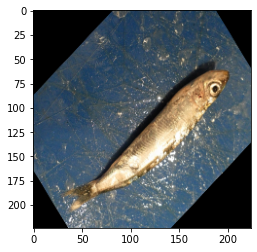

In [80]:
print(classes_dict[y[0]])
plt.imshow(X[0])

Now we can start building our dataset. First lets create a tensorflow dataset from images and labels and shuffle it. Then we can split it for train, validation and test set with ratio 80/10/10.

In [46]:
dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(len(X))
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

val_set = val_set.skip(val_size)
test_set = val_set.take(test_size)

Our purpose is to store the dataset in TFRecord files. Such files contain objects which are the serialized protocol buffers. Therefore first we have to create a function which will make such protobufs from our pairs of images and labels. We gonna use the *Example* protobuf which will contain our image as a list of byte strings (that is why we first use *serialize_tensor* function) and label as a list of integers.

In [81]:
BytesList = tf.train.BytesList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                'label': Feature(int64_list=Int64List(value=[int(label)]))
            }))

Now we can save our images in multiple TFRecord files. To do this we can iterate over all entries in the dataset and decide to which file certain record should be saved by taking the remainder of the division of the index of our record by number of files/shards. Each record is converted into a protocol buffer using *create_example* function and serialized.

In [48]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, dataset_type=None, n_shards=5):
    dirpath = 'tf_records_classification'
    paths = [dirpath + '/' + dataset_type + '/' + "{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [49]:
train_filepaths = write_tfrecords("train", train_set, dataset_type='train')
valid_filepaths = write_tfrecords("valid", val_set, dataset_type='valid')
test_filepaths = write_tfrecords("test", test_set, dataset_type='test')

To train our model on the data saved as the TFRecord files we will also have to do some preprocessing. We have to parse every example from our files and this can be done using *parse_single_example* function. We just have to specify the description of each feature so basically the length, type and default value. Then image has to be also parsed to a tensor. Since our labels are in a float format we also cast the image to float. We gonna use the pretrained Xception model which requires to preprocess the data in some specific way so we also apply the additional preprocessing function.

In [55]:
def preprocess(tfrecord):
    feature_descriptions = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = keras.applications.xception.preprocess_input(image)
    return image, example['label']

Now lets define a function which will read our files and create a dataset. We can read TFRecord files by giving filepaths to the *TFRecordDataset* function. Then we can shuffle our dataset and apply *preprocess* function using a *map* method. A a last step data should be batched and prefetched.

In [ ]:
def prep_dataset(filepaths, n_read_threads=6, shuffle_buffer_size=None,
                n_parse_threads=6, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [99]:
# If data is already prepared 
filepath_train = 'D:\ML_projects\image_classification_segmentation_project\\tf_records_classification\\train'
train_filepaths = [filepath_train + '\\' + str(filename) for filename in os.listdir(filepath_train)]
filepath_valid = 'D:\ML_projects\image_classification_segmentation_project\\tf_records_classification\\valid'
valid_filepaths = [filepath_valid + '\\' + str(filename) for filename in os.listdir(filepath_valid)]
filepath_test = 'D:\ML_projects\image_classification_segmentation_project\\tf_records_classification\\test'
test_filepaths = [filepath_test + '\\' + str(filename) for filename in os.listdir(filepath_test)]

In [56]:
train_set = prep_dataset(train_filepaths, shuffle_buffer_size=10000)
valid_set = prep_dataset(valid_filepaths)
test_set = prep_dataset(test_filepaths)

To use our pretrained model we have to load it without the top layers which we have to add ourselves. This layers will be trained and the model layers will be frozen for training so that we do not destroy the pretrained weights. If the model will stop doing any progress we can then unfreeze some of the layers. We can also define 2 callbacks so that the best model is saved and the training is stopped if our model wont do any progress for the next 5 epochs. Actual training was done on the Google Colab due to the speed cause I dont have a GPU for this.

In [103]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
custom_model = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(classes), activation='softmax')(custom_model)
model = keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('fish_model_class.h5', save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_set, epochs=15, validation_data=valid_set, callbacks=[checkpoint_cb, early_stopping])

## Inference

Lets look at the model performance and visualize it using a confusion matrix and a classification report.

In [104]:
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

model = keras.models.load_model('fish_model_class.h5')

In [105]:
yhat = np.concatenate([y for X, y in test_set], axis=0)
y_pred = model.predict(test_set)

In [115]:
y_pred_classes = np.argmax(y_pred, axis=1)
yhat = [classes_dict[i] for i in yhat]
y_pred_classes = [classes_dict[i] for i in y_pred_classes]

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        54
   Gilt-Head Bream       1.00      1.00      1.00        60
   Hourse Mackerel       0.98      1.00      0.99        61
        Red Mullet       1.00      1.00      1.00        78
     Red Sea Bream       1.00      1.00      1.00        63
          Sea Bass       1.00      0.98      0.99        56
            Shrimp       1.00      1.00      1.00        61
Striped Red Mullet       1.00      1.00      1.00        55
             Trout       1.00      1.00      1.00        52

          accuracy                           1.00       540
         macro avg       1.00      1.00      1.00       540
      weighted avg       1.00      1.00      1.00       540



<AxesSubplot:>

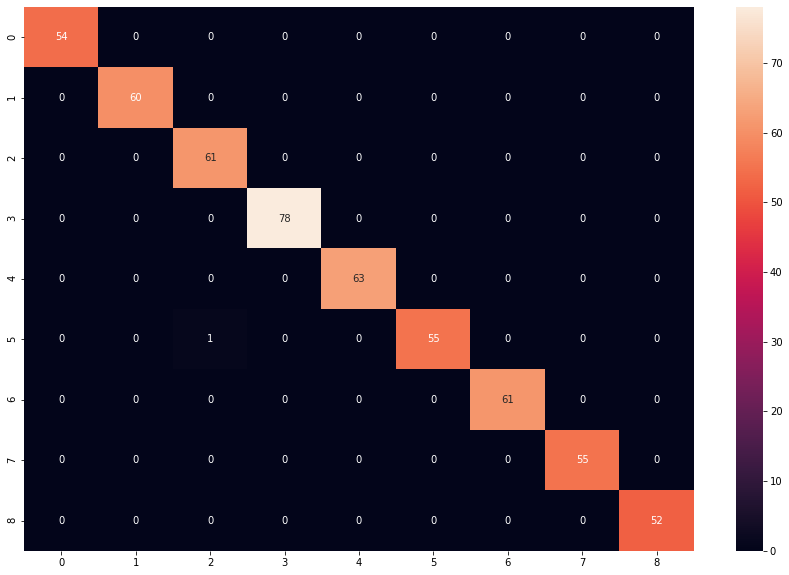

In [116]:
print(classification_report(yhat, y_pred_classes))

plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(yhat, y_pred_classes), annot=True)

It seems that our model is almost perfect but this dataset was actually pretty easy. We could have also used much smaller and simpler model and it would probably perform really good as well.

## Fit on all images with DataGenerator

As I mentioned above, one can also use the *ImageDataGenerator* and *flow_from_directory* methods to directly get the images from directory and also augment them but we cannot choose the subset of images using this method and we have to train on all of the images.

In [117]:
datagen = keras.preprocessing.image.ImageDataGenerator(
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  validation_split=0.2,
                                  preprocessing_function=keras.applications.xception.preprocess_input)

In [119]:
train_generator = datagen.flow_from_directory('D:\ML_projects\image_classification_segmentation_project\Fish_Dataset\classification',
                                                target_size=(224, 224),
                                                   batch_size=32,
                                                   shuffle=True,
                                                   class_mode='categorical',
                                                   subset='training')

valid_generator = datagen.flow_from_directory('D:\ML_projects\image_classification_segmentation_project\Fish_Dataset\classification',
                                                target_size=(224, 224),
                                                   batch_size=32,
                                                   shuffle=True,
                                                   class_mode='categorical',
                                                   subset='validation')

Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [120]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
custom_model = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(classes), activation='softmax')(custom_model)
model = keras.Model(inputs=base_model.input, outputs=output)

In [122]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, 
                    validation_data=valid_generator, 
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(valid_generator))